In [110]:
# !pip install catboost==1.2.3 numpy==1.26.4

# Ансамбли

In [111]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr

In [112]:
import numpy as np
import pandas as pd

## Регрессия

In [113]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()

In [114]:
df = pd.DataFrame(data['data'], columns=data['feature_names'])
df['target'] = data['target']

In [115]:
display(df.head())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [117]:
features = data['feature_names']
target = 'target'

In [118]:
features

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

Подготовим выборки для обучения

In [119]:
train, test = train_test_split(df, test_size=0.25, random_state=41)

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [120]:
# Функция рассчёта регрессионных метрик по которым будем сравнивать модели
def check_metrics(y_true, y_preds):

  r2 = round(r2_score(y_true, y_preds), 3) 
  # R^2 (коэффициент детерминации): [-∞, 1]. 
  # Показывает, какую долю дисперсии целевой переменной объясняет модель.
  # 1 — идеальное совпадение, 0 — модель не лучше, чем предсказание среднего, 
  # <0 — модель хуже, чем просто предсказывать среднее.

  mse = round(mean_squared_error(y_true, y_preds), 3) 
  # MSE (среднеквадратичная ошибка): [0, +∞).
  # Показывает средний квадрат разницы между предсказанными и истинными значениями.
  # 0 — идеальное совпадение, чем больше — тем хуже.

  spearman = round(spearmanr(y_true, y_preds)[0], 3) 
  # Коэффициент ранговой корреляции Спирмена: [-1, 1].
  # Оценивает, насколько хорошо сохраняется порядок (ранжирование) между y_true и y_preds.
  # 1 — идеальное совпадение рангов, 0 — нет связи, -1 — обратная связь.

  print('Unique Predicts:', len(set(y_preds)))
  print('R2:', r2)
  print('MSE:', mse)
  print('Spearman:', spearman)

  return r2, mse, spearman

In [121]:
# Вспомогательная функция для фита и рассчёта метрик

global_regression_results = {}

def fit_regression(reg, name):
  global global_regression_results

  reg.fit(X_train.values, y_train.values)
  predict_train = reg.predict(X_train.values)
  predict_test = reg.predict(X_test.values)
  print('Train:')
  train_r2, train_mse, train_spearman = check_metrics(y_train, predict_train)
  print()
  print('Test:')
  test_r2, test_mse, test_spearman = check_metrics(y_test, predict_test)

  global_regression_results[name] = {
      # Train
      'train_r2': train_r2,
      'train_mse': train_mse,
      'train_spearman': train_spearman,
      # Test
      'test_r2': test_r2,
      'test_mse': test_mse,
      'test_spearman': test_spearman,
  }

### Обычное дерево

In [122]:
# Test:
# R2: 0.628
# MSE: 0.493
# Spearman: 0.846

In [123]:
tree = DecisionTreeRegressor(max_depth=8)
fit_regression(tree, 'sklearn.tree')

Train:
Unique Predicts: 232
R2: 0.769
MSE: 0.308
Spearman: 0.867

Test:
Unique Predicts: 191
R2: 0.71
MSE: 0.384
Spearman: 0.843


### Случайный Лес (ручной)

In [124]:
from tqdm.auto import tqdm

class MyRandomForestRegressor:
  def __init__(self, num_trees=10, max_depth=5):
    self.num_trees = num_trees
    self.max_depth = max_depth

  def fit(self, X, y):
    # Создаем массив деревьев куда будем складывать обученные деревья
    self.trees = []

    # Строим деревья
    for i in tqdm(range(self.num_trees)):

      # На каждом шаге сэмплируем выборку с замещением (получаем индексы)
      bagged_indices = np.random.choice(list(range(len(X))), size=len(X), replace=True)

      # Сэмплируем по получившимся индексам выборку для i-го шага
      bagged_X = X[bagged_indices]
      bagged_y = y[bagged_indices]

      # Создаём модель и обучаем на выборку
      tree = DecisionTreeRegressor(max_depth=self.max_depth)
      tree.fit(bagged_X, bagged_y)

      # Сохраняем обученную модель
      self.trees.append(tree)

  def predict(self, X):
    # Будем складывать сюда предикты
    predicts = []

    # Пробегаемся по деревьем и считаем их предикты
    for i, tree in enumerate(self.trees):
      predicts.append(tree.predict(X))

    # Усредняем ответы деревьев для каждого наблюдения
    answer = np.mean(predicts, axis=0)
    return answer

In [125]:
my_rf = MyRandomForestRegressor(max_depth=8, num_trees=100)
fit_regression(my_rf, 'my_rf')

  0%|          | 0/100 [00:00<?, ?it/s]

Train:
Unique Predicts: 14619
R2: 0.805
MSE: 0.259
Spearman: 0.894

Test:
Unique Predicts: 4982
R2: 0.759
MSE: 0.32
Spearman: 0.874


In [126]:
pd.DataFrame(global_regression_results).T


,train_r2,train_mse,train_spearman,test_r2,test_mse,test_spearman
sklearn.tree,0.769,0.308,0.867,0.710,0.384,0.843
my_rf,0.805,0.259,0.894,0.759,0.320,0.874


### Случайный Лес (Sklearn)

In [127]:
from sklearn.ensemble import RandomForestRegressor

In [128]:
rf = RandomForestRegressor(max_depth=8, n_estimators=100)
fit_regression(rf, 'rf')

Train:
Unique Predicts: 14620
R2: 0.807
MSE: 0.258
Spearman: 0.896

Test:
Unique Predicts: 5005
R2: 0.759
MSE: 0.32
Spearman: 0.875


In [129]:
pd.DataFrame(global_regression_results).T

,train_r2,train_mse,train_spearman,test_r2,test_mse,test_spearman
sklearn.tree,0.769,0.308,0.867,0.710,0.384,0.843
my_rf,0.805,0.259,0.894,0.759,0.320,0.874
rf,0.807,0.258,0.896,0.759,0.320,0.875


### Градиентный Бустинг (Ручной)

In [130]:
# L(y, y^) = (y-y^)^2

# 2 * (y - y^) * -1

# 2 * (y^_i - y_i)

# 2 * (y_i - y^_i)

In [131]:
class MyGBDTRegressor:
  def __init__(self, num_trees=100, max_depth=5, lr=0.5):
    self.num_trees = num_trees
    self.max_depth = max_depth
    self.lr = lr

  def fit(self, X, y):
    self.trees = []

    # Будем складывать сюда ответы
    predicts = np.zeros(y.shape[0])

    for i in tqdm(range(self.num_trees)):
      tree = DecisionTreeRegressor(max_depth=self.max_depth)

      new_target = y - predicts
      tree.fit(X, new_target)

      self.trees.append(tree)

      tree_predict = tree.predict(X)
      predicts += self.lr * tree_predict

  def predict(self, X):
    predicts = np.zeros(X.shape[0])
    for i, tree in enumerate(self.trees):
      predicts += self.lr * tree.predict(X)

    return predicts

In [132]:
my_gb = MyGBDTRegressor(lr=0.1, num_trees=50, max_depth=5)
fit_regression(my_gb, 'my_gb')

  0%|          | 0/50 [00:00<?, ?it/s]

Train:
Unique Predicts: 15236
R2: 0.838
MSE: 0.215
Spearman: 0.915

Test:
Unique Predicts: 5120
R2: 0.803
MSE: 0.26
Spearman: 0.899


In [133]:
my_gb_1000 = MyGBDTRegressor(lr=0.1, num_trees=1000, max_depth=2)
fit_regression(my_gb_1000, 'my_gb_1000')

  0%|          | 0/1000 [00:00<?, ?it/s]

Train:
Unique Predicts: 15479
R2: 0.854
MSE: 0.195
Spearman: 0.927

Test:
Unique Predicts: 5160
R2: 0.817
MSE: 0.243
Spearman: 0.91


In [134]:
pd.DataFrame(global_regression_results).T

,train_r2,train_mse,train_spearman,test_r2,test_mse,test_spearman
sklearn.tree,0.769,0.308,0.867,0.710,0.384,0.843
my_rf,0.805,0.259,0.894,0.759,0.320,0.874
rf,0.807,0.258,0.896,0.759,0.320,0.875
my_gb,0.838,0.215,0.915,0.803,0.260,0.899
my_gb_1000,0.854,0.195,0.927,0.817,0.243,0.910


### LightGBM

In [135]:
# %pip install lightgbm
from lightgbm import LGBMRegressor

In [136]:
lgbm = LGBMRegressor(n_estimators=50, max_depth=5)
fit_regression(lgbm, 'lgbm')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 15480, number of used features: 8
[LightGBM] [Info] Start training from score 2,075014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\evoni\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\evoni\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### CatBoost

In [137]:
from catboost import CatBoostRegressor

In [138]:
cb = CatBoostRegressor(n_estimators=50, max_depth=5)
fit_regression(cb, 'cb')

Learning rate set to 0.5
0:	learn: 0.8901179	total: 2.12ms	remaining: 104ms
1:	learn: 0.7709543	total: 5.03ms	remaining: 121ms
2:	learn: 0.6860578	total: 7.11ms	remaining: 111ms
3:	learn: 0.6484452	total: 9.27ms	remaining: 107ms
4:	learn: 0.6146507	total: 11.3ms	remaining: 102ms
5:	learn: 0.5978820	total: 13.3ms	remaining: 97.2ms
6:	learn: 0.5855420	total: 15.2ms	remaining: 93.3ms
7:	learn: 0.5774203	total: 17.3ms	remaining: 91ms
8:	learn: 0.5632755	total: 19.4ms	remaining: 88.5ms
9:	learn: 0.5581490	total: 21.4ms	remaining: 85.5ms
10:	learn: 0.5537188	total: 23.2ms	remaining: 82.3ms
11:	learn: 0.5466727	total: 25ms	remaining: 79.2ms
12:	learn: 0.5425336	total: 26.9ms	remaining: 76.5ms
13:	learn: 0.5395299	total: 28.7ms	remaining: 73.7ms
14:	learn: 0.5339654	total: 30.6ms	remaining: 71.4ms
15:	learn: 0.5288907	total: 32.5ms	remaining: 69.1ms
16:	learn: 0.5265496	total: 34.2ms	remaining: 66.5ms
17:	learn: 0.5232539	total: 36.1ms	remaining: 64.1ms
18:	learn: 0.5197617	total: 38ms	remaini

### Линейная Регрессия

In [139]:
from sklearn.linear_model import LinearRegression

In [140]:
lr = LinearRegression()
fit_regression(lr, 'linear')

Train:
Unique Predicts: 15480
R2: 0.607
MSE: 0.524
Spearman: 0.811

Test:
Unique Predicts: 5160
R2: 0.602
MSE: 0.527
Spearman: 0.813


## Сравнение

In [141]:
pd.DataFrame(global_regression_results).T

,train_r2,train_mse,train_spearman,test_r2,test_mse,test_spearman
sklearn.tree,0.769,0.308,0.867,0.710,0.384,0.843
my_rf,0.805,0.259,0.894,0.759,0.320,0.874
rf,0.807,0.258,0.896,0.759,0.320,0.875
my_gb,0.838,0.215,0.915,0.803,0.260,0.899
my_gb_1000,0.854,0.195,0.927,0.817,0.243,0.910
lgbm,0.827,0.231,0.910,0.801,0.264,0.898
cb,0.847,0.204,0.922,0.816,0.244,0.906
linear,0.607,0.524,0.811,0.602,0.527,0.813


## Классификация

In [142]:
# Скачаем датасет
# !gdown 1nCHCT5XWio5fSN0mYNwRbEzTGL_sIcN4

In [143]:
df = pd.read_csv('loan_data.csv')

In [144]:
display(df)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


In [145]:
numeric_features = [
    'person_age',
    'person_income',
    'person_emp_exp',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_cred_hist_length',
    'credit_score'
  ]

In [146]:
categorical_features = [
    'person_gender',
    'person_education',
    'person_home_ownership',
    'loan_intent',
    'previous_loan_defaults_on_file',
  ]

In [147]:
target = 'loan_status'

In [148]:
train, test = train_test_split(df, test_size=0.25, random_state=43)

## Используем только числовые признаки

In [149]:
X_train = train[numeric_features]
y_train = train[target]

X_test = test[numeric_features]
y_test = test[target]

In [150]:
from sklearn.metrics import roc_auc_score, log_loss

# рассчёт классификационных метрик
def check_metrics_classification(y_true, y_pred):
  roc_auc = round(roc_auc_score(y_true, y_pred), 3)
  logloss = round(log_loss(y_true, y_pred), 3)
  print('ROC AUC:', roc_auc)
  print('Log Loss:', logloss)

  return roc_auc, logloss

In [151]:
from catboost import CatBoostClassifier

# Вспомогательная функция для обучения и расчета метрик классификации

global_classification_metrics = {}

def fit_clf(clf, name, values=True):
  global global_classification_metrics

  train = X_train
  test = X_test

  if values:
    train = train.values
    test = test.values

  if values:
    clf.fit(train, y_train)
  else:
    if type(clf) is CatBoostClassifier:
      clf.fit(train, y_train, cat_features=categorical_features)
    else:
      clf.fit(train, y_train)

  predict_train = clf.predict_proba(train)[:, 1]
  predict_test = clf.predict_proba(test)[:, 1]
  print('Train:')
  train_roc_auc, train_log_loss = check_metrics_classification(y_train, predict_train)
  print()
  print('Test:')
  test_roc_auc, test_log_loss = check_metrics_classification(y_test, predict_test)

  global_classification_metrics[name] = {
      # Train
      'train_roc_auc': train_roc_auc,
      'train_log_loss': train_log_loss,
      # Test
      'test_roc_auc': test_roc_auc,
      'test_log_loss': test_log_loss
  }

In [152]:
def sigmoid(x):
  return 1.0/(1+np.exp(-x))

### Градиентный бустинг (ручной)

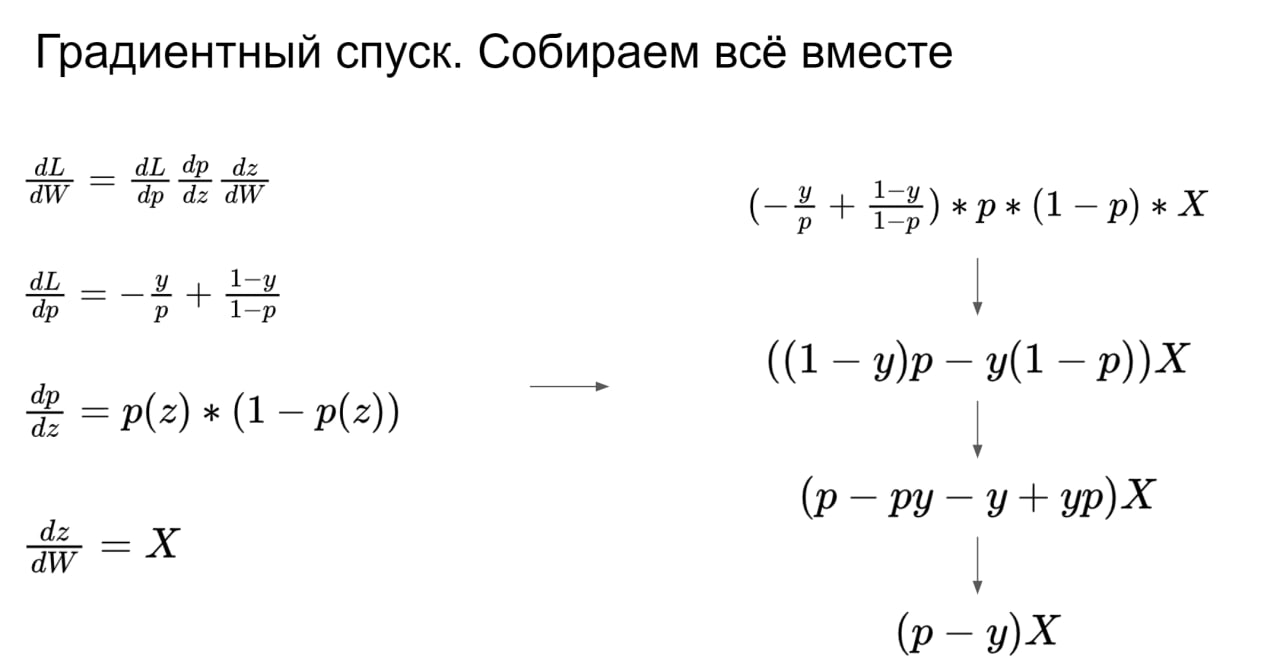

In [ ]:
class MyGBDTClassifier:
  def __init__(self, num_trees=100, max_depth=5, lr=0.5):
    self.num_trees = num_trees
    self.max_depth = max_depth
    self.lr = lr

  def fit(self, X, y):
    self.trees = []

    # Будем складывать сюда ответы
    predicts = np.zeros(y.shape[0])

    for i in range(self.num_trees):
      tree = DecisionTreeRegressor(max_depth=self.max_depth)

      # только следующие 2 строки отличаются от регрессии
      # Добавляем переход из logit в proba
      proba = sigmoid(predicts)

      # Градиент для каждого наблюдения
      new_target = y - proba
      tree.fit(X, new_target)

      self.trees.append(tree)

      tree_predict = tree.predict(X)
      predicts += self.lr * tree_predict

  def predict_proba(self, X):
    logits = np.zeros(X.shape[0])
    for i, tree in enumerate(self.trees):
      logits += self.lr * tree.predict(X)

    proba = sigmoid(logits)

    return np.vstack([1.0-proba, proba]).T

In [154]:
gb_clf = MyGBDTClassifier()
fit_clf(gb_clf, 'gb_clf')

Train:
ROC AUC: 0.909
Log Loss: 0.298

Test:
ROC AUC: 0.894
Log Loss: 0.321


### LightGBM

In [155]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=100, max_depth=5)
fit_clf(lgbm_clf, 'lgbm_clf')

[LightGBM] [Info] Number of positive: 7539, number of negative: 26211
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1200
[LightGBM] [Info] Number of data points in the train set: 33750, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,223378 -> initscore=-1,246090
[LightGBM] [Info] Start training from score -1,246090
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\evoni\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\evoni\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### CatBoost

от слова category, а не котики

In [156]:
from catboost import CatBoostClassifier
cb_clf = CatBoostClassifier(n_estimators=100, max_depth=5)
fit_clf(cb_clf, 'cb_clf')

Learning rate set to 0.38239
0:	learn: 0.5235740	total: 2.71ms	remaining: 268ms
1:	learn: 0.4469527	total: 5.22ms	remaining: 256ms
2:	learn: 0.4026491	total: 7.76ms	remaining: 251ms
3:	learn: 0.3790385	total: 10ms	remaining: 241ms
4:	learn: 0.3654017	total: 12.1ms	remaining: 231ms
5:	learn: 0.3579543	total: 14.2ms	remaining: 223ms
6:	learn: 0.3539998	total: 16.3ms	remaining: 217ms
7:	learn: 0.3501113	total: 18.5ms	remaining: 213ms
8:	learn: 0.3478406	total: 20.6ms	remaining: 208ms
9:	learn: 0.3461976	total: 22.8ms	remaining: 205ms
10:	learn: 0.3441368	total: 25.1ms	remaining: 203ms
11:	learn: 0.3427905	total: 27.3ms	remaining: 200ms
12:	learn: 0.3413982	total: 29.5ms	remaining: 198ms
13:	learn: 0.3402919	total: 31.9ms	remaining: 196ms
14:	learn: 0.3398232	total: 34.1ms	remaining: 193ms
15:	learn: 0.3393890	total: 36.2ms	remaining: 190ms
16:	learn: 0.3386400	total: 38.4ms	remaining: 187ms
17:	learn: 0.3376562	total: 40.4ms	remaining: 184ms
18:	learn: 0.3372509	total: 42.4ms	remaining: 1

### LogisticRegression

In [157]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
fit_clf(lr, 'logistic')

Train:
ROC AUC: 0.811
Log Loss: 0.424

Test:
ROC AUC: 0.814
Log Loss: 0.415


c:\Users\evoni\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Попробуем использовать категориальные признаки

In [158]:
X_train = train[categorical_features]
X_test = test[categorical_features]

In [159]:
X_train[categorical_features] = X_train[categorical_features].astype('category')
X_test[categorical_features] = X_test[categorical_features].astype('category')

C:\Users\evoni\AppData\Local\Temp\ipykernel_23832\1836999323.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[categorical_features] = X_train[categorical_features].astype('category')
C:\Users\evoni\AppData\Local\Temp\ipykernel_23832\1836999323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[categorical_features] = X_test[categorical_features].astype('category')


### LightGBM

In [160]:
lgbm_clf = LGBMClassifier()
fit_clf(lgbm_clf, 'lgbm_clf_cat_only', values=False)

[LightGBM] [Info] Number of positive: 7539, number of negative: 26211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23
[LightGBM] [Info] Number of data points in the train set: 33750, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,223378 -> initscore=-1,246090
[LightGBM] [Info] Start training from score -1,246090
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Train:
ROC AUC: 0.897
Log Loss: 0.304

Test:
ROC AUC: 0.9
Log Loss: 0.299


### CatBoost

In [161]:
cb_clf = CatBoostClassifier()
fit_clf(cb_clf, 'cb_clf_cat_only', values=False)

Learning rate set to 0.046292
0:	learn: 0.5981829	total: 30.5ms	remaining: 30.5s
1:	learn: 0.5236802	total: 48.9ms	remaining: 24.4s
2:	learn: 0.4699546	total: 72.2ms	remaining: 24s
3:	learn: 0.4316259	total: 107ms	remaining: 26.6s
4:	learn: 0.4053623	total: 140ms	remaining: 27.9s
5:	learn: 0.3847056	total: 173ms	remaining: 28.6s
6:	learn: 0.3696520	total: 211ms	remaining: 29.9s
7:	learn: 0.3585225	total: 238ms	remaining: 29.6s
8:	learn: 0.3503580	total: 276ms	remaining: 30.4s
9:	learn: 0.3437944	total: 314ms	remaining: 31.1s
10:	learn: 0.3386990	total: 347ms	remaining: 31.2s
11:	learn: 0.3345743	total: 382ms	remaining: 31.5s
12:	learn: 0.3310699	total: 445ms	remaining: 33.8s
13:	learn: 0.3282725	total: 475ms	remaining: 33.4s
14:	learn: 0.3258268	total: 512ms	remaining: 33.6s
15:	learn: 0.3237852	total: 545ms	remaining: 33.5s
16:	learn: 0.3220348	total: 582ms	remaining: 33.6s
17:	learn: 0.3205321	total: 620ms	remaining: 33.8s
18:	learn: 0.3192223	total: 672ms	remaining: 34.7s
19:	learn:

## Попробуем смешать и категориальные и числовые признаки

In [162]:
X_train = train[numeric_features + categorical_features]
X_test = test[numeric_features + categorical_features]

In [163]:
X_train[categorical_features] = X_train[categorical_features].astype('category')
X_test[categorical_features] = X_test[categorical_features].astype('category')

C:\Users\evoni\AppData\Local\Temp\ipykernel_23832\1836999323.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[categorical_features] = X_train[categorical_features].astype('category')
C:\Users\evoni\AppData\Local\Temp\ipykernel_23832\1836999323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[categorical_features] = X_test[categorical_features].astype('category')


### LightGBM

In [164]:
lgbm_clf = LGBMClassifier()
fit_clf(lgbm_clf, 'lgbm_clf_cat_and_num', values=False)

[LightGBM] [Info] Number of positive: 7539, number of negative: 26211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1223
[LightGBM] [Info] Number of data points in the train set: 33750, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,223378 -> initscore=-1,246090
[LightGBM] [Info] Start training from score -1,246090
Train:
ROC AUC: 0.988
Log Loss: 0.124

Test:
ROC AUC: 0.98
Log Loss: 0.144


### CatBoost

In [165]:
cb_clf = CatBoostClassifier()
fit_clf(cb_clf, 'cb_clf_cat_and_num', values=False)

Learning rate set to 0.046292
0:	learn: 0.5872339	total: 46.7ms	remaining: 46.7s
1:	learn: 0.5101402	total: 89.2ms	remaining: 44.5s
2:	learn: 0.4487523	total: 128ms	remaining: 42.6s
3:	learn: 0.4015159	total: 169ms	remaining: 42.1s
4:	learn: 0.3628570	total: 210ms	remaining: 41.7s
5:	learn: 0.3331829	total: 259ms	remaining: 42.8s
6:	learn: 0.3114675	total: 301ms	remaining: 42.7s
7:	learn: 0.2928719	total: 342ms	remaining: 42.4s
8:	learn: 0.2798342	total: 385ms	remaining: 42.4s
9:	learn: 0.2698058	total: 427ms	remaining: 42.3s
10:	learn: 0.2601966	total: 471ms	remaining: 42.3s
11:	learn: 0.2531532	total: 512ms	remaining: 42.2s
12:	learn: 0.2464496	total: 555ms	remaining: 42.2s
13:	learn: 0.2414626	total: 599ms	remaining: 42.2s
14:	learn: 0.2370527	total: 642ms	remaining: 42.2s
15:	learn: 0.2325576	total: 683ms	remaining: 42s
16:	learn: 0.2294515	total: 725ms	remaining: 41.9s
17:	learn: 0.2262624	total: 766ms	remaining: 41.8s
18:	learn: 0.2234772	total: 808ms	remaining: 41.7s
19:	learn: 

## Сравнение

In [166]:
pd.DataFrame(global_classification_metrics).T

,train_roc_auc,train_log_loss,test_roc_auc,test_log_loss
gb_clf,0.909,0.298,0.894,0.321
lgbm_clf,0.910,0.299,0.895,0.319
cb_clf,0.902,0.307,0.893,0.320
logistic,0.811,0.424,0.814,0.415
lgbm_clf_cat_only,0.897,0.304,0.900,0.299
cb_clf_cat_only,0.896,0.306,0.901,0.299
lgbm_clf_cat_and_num,0.988,0.124,0.980,0.144
cb_clf_cat_and_num,0.987,0.124,0.979,0.146


# Feature Importance(Важность Признаков)

In [167]:
import lightgbm

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

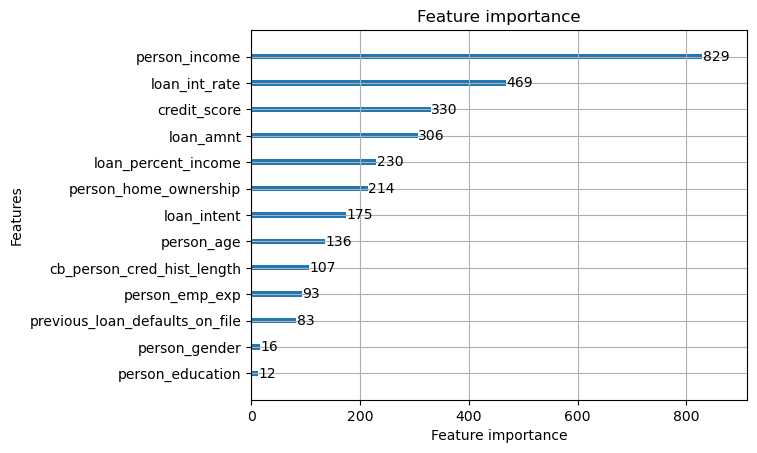

In [168]:
lightgbm.plot_importance(lgbm_clf)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

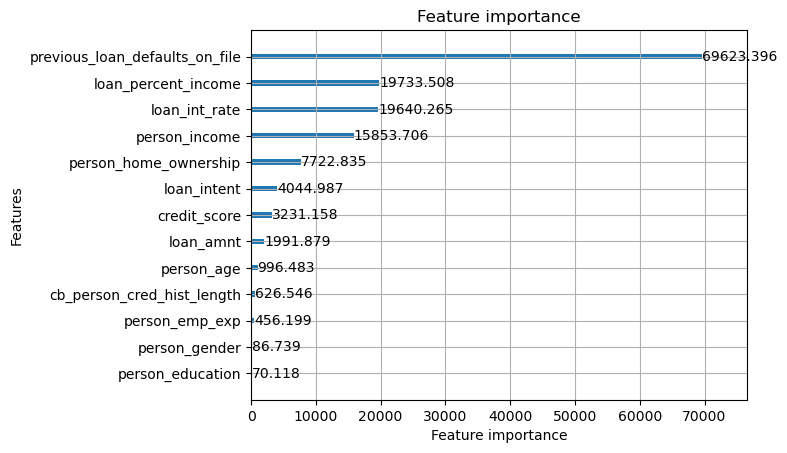

In [169]:
lightgbm.plot_importance(lgbm_clf, importance_type='gain')

**коррелирующие признаки могут снизить importance для модели**

Оценим каждую фичу в отдельности (можно и не строя модель)

In [170]:
def gini(y_true, score):
  return 2 * roc_auc_score(y_true, score) - 1

In [171]:
stats = []
for feature in numeric_features:
  stats.append({
      'feature': feature,
      'gini': abs(gini(y_train, X_train[feature]))
  })
stats = pd.DataFrame(stats)
display(stats.sort_values('gini'))

,feature,gini
7,credit_score,0.011783
6,cb_person_cred_hist_length,0.028500
2,person_emp_exp,0.035041
0,person_age,0.041461
3,loan_amnt,0.124365
1,person_income,0.374407
4,loan_int_rate,0.433324
5,loan_percent_income,0.447723


### Permutation Importance

На обученной модели берём конкретную фичу и делаем shuffle значений внутри выборки, то есть у конкретного наблюдение будет не его корректное значение фичи, а чье-то другое.

Мы сохраняе распределение фичи на уровне выборки, но при этом ломаем связь между фичей и наблюдением.

Смотрим как изменяются метрики - сильно значит модель сильно опирается на эту фичу, если почти не изменяются - возможно модель почти не смотрит на этй фичу

---

### Propensity Score

Оценка стабильности фичей с помощью Propensity Score.

Смешиваем Train/Test выборки, добавляя бинарный флаг (1 если наблюдение из Train, 0 иначе)

Строим модель на фичах, которая предсказывает этот флаг. Если имеем хорошее качество - выборки почему-то отличаются, можно посмотреть на feature importance модели, чтобы понять на какие фичи она в основном опиралас - скорее всего их распределение отличается между выборками (если Test - Out of Time, это может говорить о Data Drift)

---
## ДЗ

Добавить в Random Forest и Gradient Boosting выбор случайного набора фичей для построения каждого отдельного дерева.

**Необходимо** использовать реализованные деревья из прошлой домашки (реализовать для задачи регрессии)



In [ ]:
class MyRandomForestRegressor:
  def __init__(self, num_trees=10, max_depth=5, features_by_tree_strategy='sqrt'):
    '''
    features_by_tree_strategy - всего 3 варианта: half, sqrt и other
    '''
    self.num_trees = num_trees
    self.max_depth = max_depth
    self.features_by_tree_strategy = features_by_tree_strategy # Запомним стратегию выбора фией
    self.features_idx = []


  def fit(self, X, y):
    # Создаем массив деревьев куда будем складывать обученные деревья
    self.trees = []

    # Кол-во фичей
    n_cols = X.shape[1]

    # В зависимости от стратегии использования фичей ограничиваем максимальное кол-во фичей для каждого дерева
    if self.features_by_tree_strategy == 'sqrt':
      # Не больше корня от кол-ва фичей
      n_cols_by_tree = int(np.ceil(n_cols**0.5))
    elif self.features_by_tree_strategy == 'half':
      # Не больше половины от кол-ва фичей
      n_cols_by_tree = int(np.ceil(n_cols*0.5))
    else:
      # Все фичи
      n_cols_by_tree = n_cols

    # Строим деревья
    for i in range(self.num_trees):
      idxs = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
      X_bootstrap = X[idxs]
      y_bootstrap = y[idxs]

      features = np.random.choice(n_cols, size=n_cols_by_tree, replace=False)
      X_bootstrap_selected = X_bootstrap[:, features]

      tree = DecisionTreeRegressor(max_depth=self.max_depth)
      tree.fit(X_bootstrap_selected, y_bootstrap)

      self.trees.append(tree)
      self.features_idx.append(features)


  def predict(self, X):
    # Будем складывать сюда предикты
    predicts = []

    # Пробегаемся по деревьем и считаем их предикты
    for i, tree in enumerate(self.trees):
      features = self.features_idx[i]
      X_selected = X[:, features]
      pred = tree.predict(X_selected)
      predicts.append(pred)

    # Усредняем ответы деревьев для каждого наблюдения
    answer = np.mean(predicts, axis=0)
    return answer

Тоже самое сделать для бустинга

In [ ]:
class MyGBDTRegressor:
  def __init__(self, num_trees=100, max_depth=5, lr=0.5, features_by_tree_strategy='sqrt'):
    self.num_trees = num_trees
    self.max_depth = max_depth
    self.lr = lr
    self.features_by_tree_strategy = features_by_tree_strategy
    self.trees = []
    self.features_indices = []
    self.init_value = None

  def _get_num_features(self, n_features):
    if self.features_by_tree_strategy == 'sqrt':
      return max(1, int(np.sqrt(n_features)))
    elif self.features_by_tree_strategy == 'log2':
      return max(1, int(np.log2(n_features)))
    elif self.features_by_tree_strategy == 'all':
      return n_features
    else:
      raise ValueError("Unknown features_by_tree_strategy")

  def fit(self, X, y):
    X = np.array(X)
    y = np.array(y)
    n_samples, n_features = X.shape

    self.init_value = np.mean(y)
    y_pred = np.full(n_samples, self.init_value)

    for i in range(self.num_trees):
      # Выбор случайных признаков для этого дерева
      num_feats = self._get_num_features(n_features)
      feats_idx = np.random.choice(n_features, num_feats, replace=False)
      self.features_indices.append(feats_idx)

      # Остатки (градиенты)
      residuals = y - y_pred

      # Обучаем дерево на выбранных признаках
      tree = DecisionTreeRegressor(max_depth=self.max_depth)
      tree.fit(X[:, feats_idx], residuals)
      self.trees.append(tree)

      # Обновляем предсказания
      y_pred += self.lr * tree.predict(X[:, feats_idx])

  def predict(self, X):
    X = np.array(X)
    y_pred = np.full(X.shape[0], self.init_value)
    for tree, feats_idx in zip(self.trees, self.features_indices):
        y_pred += self.lr * tree.predict(X[:, feats_idx])
    return y_pred

Сравнить результаты от изменения параметра - кол-во фичей для построения дерева. Сравнить с RandomForestRegressor из scikit-learn.